## 카드 소비 데이터

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import dask.dataframe as dd
import vaex
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst

csv_files = [
    '../data/five_city_data/merged_data_gm.csv',
    '../data/five_city_data/merged_data_hs.csv',
    '../data/five_city_data/merged_data_sh.csv',
    '../data/five_city_data/merged_data_sw.csv',
    '../data/five_city_data/merged_data_yy.csv'
]
file_path = '../data/five_city_data/merged_data_hs.csv'
card_df = dd.read_csv(file_path,encoding='utf-8')
print("data load 완료...")

time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()
print("1단계: group by 완료")
time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()
print("2단계: group by 완료")
time_df2 = time_df2.compute()
time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')
print("3단계:날짜 타입 변환")

train_df = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
print("4단계:날짜 정렬")
print(len(train_df))
print("data 전처리 완료...")
train_data = TimeSeriesDataFrame.from_data_frame(train_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

print("학습 시작...")
predictor = TimeSeriesPredictor(
    label="amt", 
    prediction_length=90, 
    eval_metric="RMSE", 
    path=os.path.join('models2', os.path.basename(file_path).replace('.csv', '')),
    freq="D")

hyperparameters = {
    'AutoARIMA': {
        'seasonal': True,  # 계절성 데이터인지 여부
        'max_p': 5,        # AR(p) 모델의 최대 p 값
        'max_d': 2,        # 차분 차수
        'max_q': 5,        # MA(q) 모델의 최대 q 값
        'max_order': 10,   # 최대 p + d + q 값
        'maxiter': 50,     # 최적화 반복 횟수
    },
    'ETS': {
        'seasonal': 'add', # 계절성 구성 요소 ('add', 'mul', 'none')
        'damped': True,    # 감쇠 추세 여부
    },
    'Prophet': {
        'yearly_seasonality': True,  # 연간 계절성 여부
        'weekly_seasonality': False, # 주간 계절성 여부
        'daily_seasonality': False,  # 일일 계절성 여부
    },
    'SimpleFeedForward': {
        'epochs': 20,       # 학습 에폭 수
        'batch_size': 32,   # 배치 크기
        'learning_rate': 1e-3,  # 학습률
    },
}

predictor.fit(
    train_data,
    hyperparameters=hyperparameters,
    random_seed=42,
    time_limit=1800
)


predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'D'.


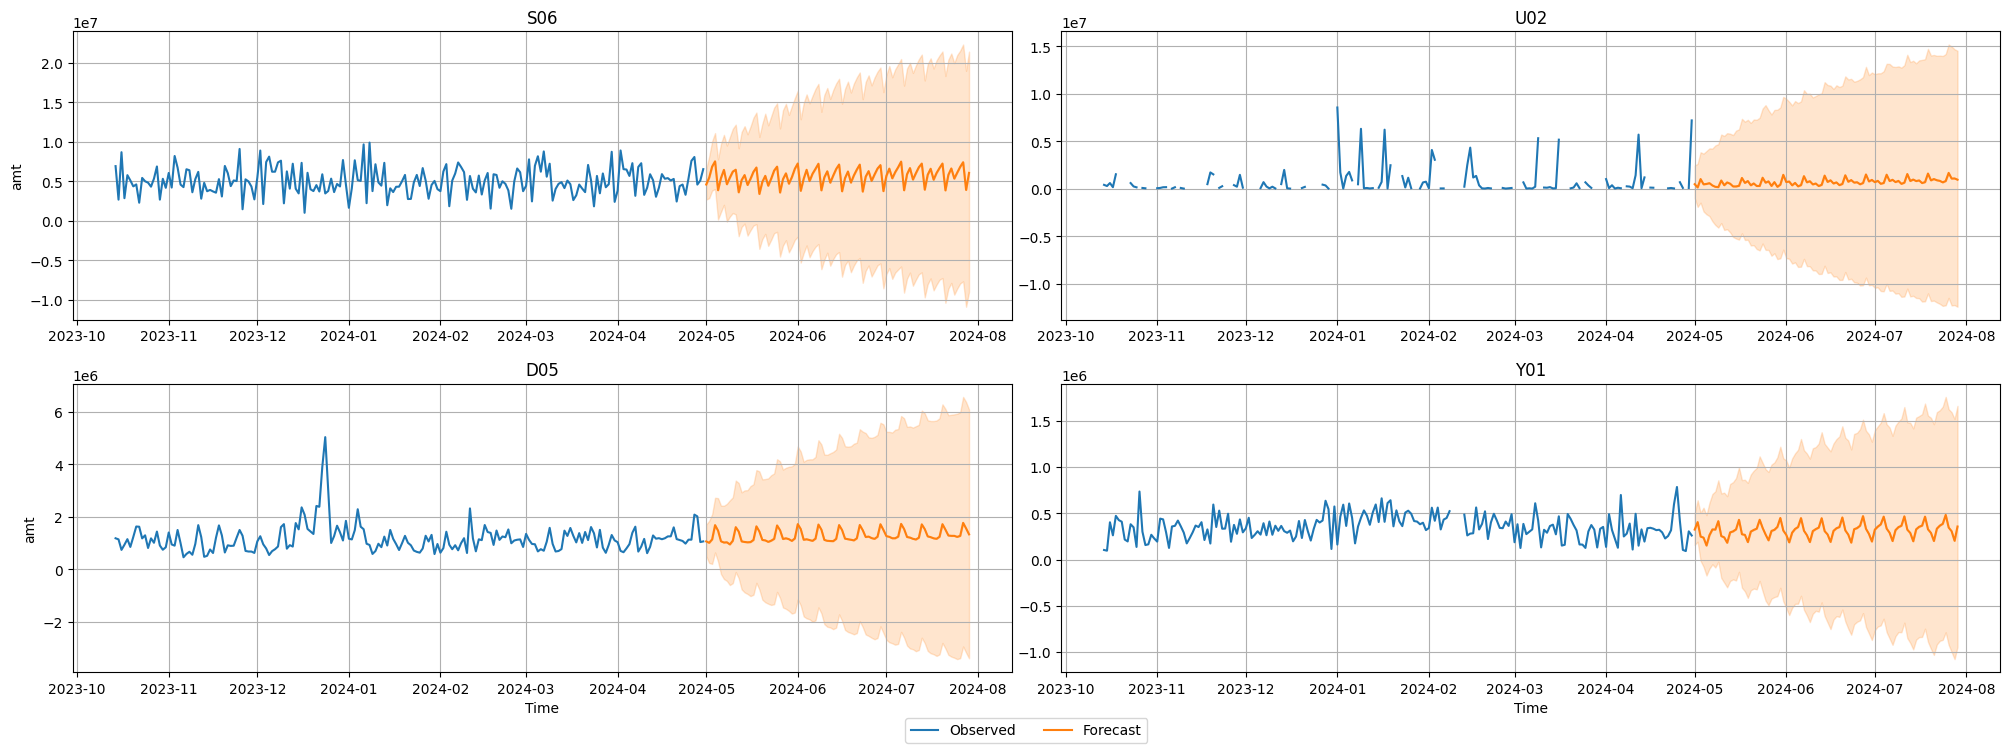

In [6]:
predictor.plot(train_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

## 하이퍼파리미터 튜닝코드

In [13]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os

csv_files = [
    '../data/five_city_data/merged_data_gm.csv',
    '../data/five_city_data/merged_data_hs.csv',
    '../data/five_city_data/merged_data_sh.csv',
    '../data/five_city_data/merged_data_sw.csv',
    '../data/five_city_data/merged_data_yy.csv'
]
file_path = '../data/five_city_data/merged_data_sw.csv'
card_df = dd.read_csv(file_path, encoding='utf-8')
print("data load 완료...")

time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()
print("1단계: group by 완료")
time_df2 = time_df.groupby(['ta_ymd', 'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()
print("2단계: group by 완료")
time_df2 = time_df2.compute()
time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')
print("3단계:날짜 타입 변환")

# 로그 변환 적용
time_df2['amt'] = np.log1p(time_df2['amt'])

train_df = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
print("4단계:날짜 정렬")
print(len(train_df))
print("data 전처리 완료...")
train_data = TimeSeriesDataFrame.from_data_frame(train_df, id_column="card_tpbuz_cd", timestamp_column="ta_ymd")

print("학습 시작...")
predictor = TimeSeriesPredictor(
    label="amt", 
    prediction_length=90, 
    eval_metric="RMSE", 
    path=os.path.join('models2', os.path.basename(file_path).replace('.csv', '')),
    freq="D"
)

# 하이퍼파라미터 조정
hyperparameters = {
    'AutoARIMA': {
        'seasonal': True,  # 계절성 데이터인지 여부
        'max_p': 5,        # AR(p) 모델의 최대 p 값
        'max_d': 2,        # 차분 차수
        'max_q': 5,        # MA(q) 모델의 최대 q 값
        'max_order': 10,   # 최대 p + d + q 값
        'maxiter': 50,     # 최적화 반복 횟수
    },
    'ETS': {
        'seasonal': 'add', # 계절성 구성 요소 ('add', 'mul', 'none')
        'damped': True,    # 감쇠 추세 여부
    },
    'SimpleFeedForward': {
        'epochs': 20,       # 학습 에폭 수
        'batch_size': 32,   # 배치 크기
        'learning_rate': 1e-3,  # 학습률
    },
}

predictor.fit(
    train_data,
    hyperparameters=hyperparameters,
    random_seed=42,
    time_limit=1800
)

predictions = predictor.predict(train_data)
predictions.head()

# 로그 변환을 다시 원래 값으로 변환
predictions['mean'] = np.expm1(predictions['mean'])

# 결과를 저장하거나 시각화할 수 있습니다.
predictions.to_csv("predictions.csv")
print("예측 결과 저장 완료")


data load 완료...
1단계: group by 완료
2단계: group by 완료


Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to 'models2\merged_data_sw'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       14.82 GB / 31.69 GB (46.8%)
Disk Space Avail:   550.09 GB / 930.86 GB (59.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': {'AutoARIMA': {'max_d': 2,
                                   'max_order': 10,
                                   'max_p': 5,
                                   'max_q': 5,
                                   'maxiter': 50,
                                   'seasonal': True},
                     'ETS': {'damped': True, 'seasonal': 'add'},
                     'SimpleFeedForward': {'batch_size': 32,
                                           'epochs'

3단계:날짜 타입 변환
4단계:날짜 정렬
39625
data 전처리 완료...
학습 시작...


Provided train_data has 40331 rows (NaN fraction=1.8%), 83 time series. Median time series length is 486 (min=484, max=486). 

Provided data contains following columns:
	target: 'amt'

AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-17 14:54:11
Models that will be trained: ['ETS', 'AutoARIMA', 'SimpleFeedForward']
Training timeseries model ETS. Training for up to 449.7s of the 1798.7s of remaining time.
ETS\W0 ignores following hyperparameters: ['seasonal']. See the docstring of ETS\W0 for the list of supported hyperparameters.
	-0.6341       = Validation score (-RMSE)
	0.07    s     = Training runtime
	43.65   s     = Validation (prediction) runtime
Training timeseries model AutoARIMA. Training for up to 585.0s of the 1755.0s of remaining time.
AutoARIMA\W0 ignores following hyp

예측 결과 저장 완료


In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import dask.dataframe as dd
import vaex
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst

In [3]:
file_path = '../data/five_city_data/merged_gyeonggi_day.csv'
df = dd.read_csv(file_path,encoding='utf-8')

In [5]:
df = df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
df.head(10)

,ta_ymd,cty_rgn_no,admi_cty_no,card_tpbuz_cd,card_tpbuz_nm_1,card_tpbuz_nm_2,hour,sex,age,day,amt,cnt
299,20230101,41210,41210540,D01,소매/유통,가전제품,7,M,5,7,17614,2
1752,20230101,41210,41210550,D01,소매/유통,가전제품,6,F,5,7,18939,2
4442,20230101,41210,41210580,D01,소매/유통,가전제품,4,M,4,7,32121,4
4443,20230101,41210,41210580,D01,소매/유통,가전제품,4,M,6,7,16061,4
4444,20230101,41210,41210580,D01,소매/유통,가전제품,5,M,6,7,17576,4
6156,20230101,41210,41210610,D01,소매/유통,가전제품,3,F,6,7,5601288,4
6157,20230101,41210,41210610,D01,소매/유통,가전제품,3,F,7,7,1895748,4
6158,20230101,41210,41210610,D01,소매/유통,가전제품,3,F,8,7,3999053,2
6159,20230101,41210,41210610,D01,소매/유통,가전제품,3,M,5,7,8188,2
6160,20230101,41210,41210610,D01,소매/유통,가전제품,3,M,6,7,127955,4


In [7]:
time_df = df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()

In [8]:
len(time_df)

3355013

In [10]:
time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()

In [11]:
len(time_df2)

40125

In [ ]:
unique_combinations = time_df.drop_duplicates(subset=['ta_ymd','admi_cty_no', 'card_tpbuz_cd'])
unique_count = len(unique_combinations)

In [6]:
# Dask로 5개 주요시 데이터 읽기
card_df = dd.read_csv(data,encoding='utf-8')

card_df['item_id'] = card_df['card_tpbuz_cd']

# 'ta_ymd' 열을 'timestamp' 형식으로 변환

# 시갑별, 성별로 나눠져있는 하루의 데이터를 group
time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()

time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()

time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')
train_df = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
train_data.reset_index()



In [8]:
card_df['item_id'] = card_df['card_tpbuz_cd']

# 'ta_ymd' 열을 'timestamp' 형식으로 변환
card_df['timestamp'] = dd.to_datetime(card_df['ta_ymd'], format='%Y%m%d')


In [9]:
# item_id, year, month별로 그룹화하여 데이터 포인트 수 계산
grouped = card_df.groupby(['item_id', 'year', 'month']).size().reset_index()
grouped = grouped.rename(columns={0: 'count'})

# 데이터 포인트 수가 28일 미만인 그룹 필터링
result = grouped[grouped['count'] < 28]

# 결과를 pandas 데이터프레임으로 변환하여 출력
result_pd = result.compute()
print(result_pd)

   item_id  year  month  count
79     Y02  2023      1     19


### 코드를 위한 데이터 분리 및 결합

In [10]:
# 해당 일의 해당동의 업종 별 매출 총합
time_df = card_df.groupby(["ta_ymd", "admi_cty_no", "card_tpbuz_cd"]).agg({"amt": "sum"}).reset_index()
time_df.head()

,ta_ymd,admi_cty_no,card_tpbuz_cd,amt
0,20230101,41210510,D05,57576
1,20230101,41210510,D11,16546
2,20230101,41210510,F02,313388
3,20230101,41210510,Q01,69266
4,20230101,41210510,Q15,78222


In [11]:
# time_df의 해당 일의 해당 업종의 평균
time_df2 = time_df.groupby(['ta_ymd',	'card_tpbuz_cd']).agg({"amt": "mean"}).reset_index()

In [12]:
time_df2.head()

,ta_ymd,card_tpbuz_cd,amt
0,20230101,D05,1.771281e+06
1,20230101,D11,1.324731e+08
2,20230101,F02,5.639770e+06
3,20230101,Q01,7.986803e+06
4,20230101,Q15,3.868718e+07


In [15]:
time_df2 = time_df2.compute()

In [16]:
# time_df2['ta_ymd'] = time_df2['ta_ymd'].astype(str)
time_df2['ta_ymd'] = pd.to_datetime(time_df2['ta_ymd'], format='%Y%m%d')

## 모델 학습 -> AutoML 활용

In [17]:
# autogluon 사용
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [18]:
# train, test 분리
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(time_df2, test_size=0.2, random_state=42)
time_df2 = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])

In [68]:
# 각 그룹별로 train/test 데이터 나누기
# train_list = []
# test_list = []

# for card, group in time_df2.groupby('card_tpbuz_cd'):
#     train, test = train_test_split(group, test_size=0.2, shuffle=False)  # 시간 순서를 유지하여 분할
#     train_list.append(train)
#     test_list.append(test)

# # train/test 데이터 합치기
# train_df = pd.concat(train_list)
# test_df = pd.concat(test_list)


# train/test 데이터 나누기 (2024년 4월 데이터를 테스트 데이터로)
# train_df = time_df2[time_df2['ta_ymd'] < '2024-04-01']
# test_df = time_df2[time_df2['ta_ymd'] >= '2024-04-01']

# train_df = train_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
# test_df = test_df.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])
train_df = time_df2.sort_values(by=['card_tpbuz_cd', 'ta_ymd'])

In [63]:
test_df

,ta_ymd,card_tpbuz_cd,amt
37676,2024-04-01,D01,7.893328e+06
37752,2024-04-02,D01,5.459204e+06
37825,2024-04-03,D01,4.194104e+06
37900,2024-04-04,D01,4.994320e+06
37980,2024-04-05,D01,6.184189e+06
...,...,...,...
39573,2024-04-26,Y05,5.566139e+05
40067,2024-04-27,Y05,3.809042e+05
40077,2024-04-28,Y05,1.297536e+06
40081,2024-04-29,Y05,3.273625e+05


In [69]:
train_data = TimeSeriesDataFrame.from_data_frame(train_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

In [70]:
train_data.reset_index()

,item_id,timestamp,amt
0,D01,2023-01-01,3.294127e+07
1,D01,2023-01-02,9.546636e+06
2,D01,2023-01-03,4.882851e+06
3,D01,2023-01-04,5.893133e+06
4,D01,2023-01-05,4.803527e+06
...,...,...,...
40120,Y05,2024-04-26,5.566139e+05
40121,Y05,2024-04-27,3.809042e+05
40122,Y05,2024-04-28,1.297536e+06
40123,Y05,2024-04-29,3.273625e+05


In [56]:
# train_data = TimeSeriesDataFrame.from_data_frame(time_df2, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

In [57]:
# train_data = train_data.sort_values(by=['item_id', 'timestamp'])

In [71]:
predictor = TimeSeriesPredictor(label="amt", prediction_length=120, eval_metric="RMSE", freq="D")

In [72]:
predictor.fit(train_data, random_seed = 42,time_limit=3600)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'AutogluonModels\ag-20240716_004738'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       15.80 GB / 31.69 GB (49.9%)
Disk Space Avail:   547.60 GB / 930.86 GB (58.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 120,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'amt',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'D'.
Provided train_data has 40334 rows (NaN fraction=0.5%

In [73]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: NPTS


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
D01     2024-05-01  6.857686e+06  5.616520e+06  5.744465e+06  6.063691e+06   
        2024-05-02  6.686127e+06  4.994320e+06  5.519152e+06  6.105935e+06   
        2024-05-03  8.172650e+06  6.447264e+06  6.865935e+06  7.006400e+06   
        2024-05-04  1.373188e+07  9.134811e+06  1.160301e+07  1.217824e+07   
        2024-05-05  1.829739e+07  1.182168e+07  1.446939e+07  1.479469e+07   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
D01     2024-05-01  6.135180e+06  6.390952e+06  6.639562e+06  7.002766e+06   
        2024-05-02  6.371670e+06  6.595003e+06  6.904262e+06  7.283351e+06   
        2024-05-03  7.461895e+06  7.827171e+06  8.320821e+06  8.698838e+06   
        2024-05-04  1.291769e+07  1.362320e+07  1.425663e+07  1.484694e+07   
        2024-05-05  1.579956e+07  1.677888e+07  1.826243e+07  1.963439e+07   

                             0.8           0.9  
item_id timestamp                               
D01     2024-05-01  7.577377e+06  8.267800e+06  
        2024-05-02  7.385164e+06  8.486833e+06  
        2024-05-03  9.294575e+06  9.655078e+06  
        2024-05-04  1.608327e+07  1.918598e+07  
        2024-05-05  2.223668e+07  2.466454e+07

In [65]:
# import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_data_frame(test_df, id_column = "card_tpbuz_cd", timestamp_column="ta_ymd")

# Plot 4 randomly chosen time series and the respective forecasts
# predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [ ]:
predictor.leaderboard(test_data)

In [ ]:
# item_id가 'D05'인 데이터만 필터링
# train_df = train_data.reset_index()
# d05_df = train_df[train_df['item_id'] == 'F11']


In [66]:
train_data.tail()

amt
item_id timestamp               
Y05     2024-03-27  1.249378e+06
        2024-03-28  2.515191e+05
        2024-03-29  2.155825e+05
        2024-03-30  2.432951e+05
        2024-03-31  2.685809e+05

In [67]:
predictor.predict(test_data)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
D01     2024-05-01  6.460687e+06  4.061025e+06  4.130357e+06  5.558188e+06   
        2024-05-02  5.666301e+06  4.831180e+06  4.900512e+06  5.286580e+06   
        2024-05-03  6.698666e+06  6.021371e+06  6.090703e+06  6.631927e+06   
        2024-05-04  1.294860e+07  8.833863e+06  8.903196e+06  1.267487e+07   
        2024-05-05  1.610427e+07  1.044983e+07  1.051916e+07  1.420496e+07   
...                          ...           ...           ...           ...   
Y05     2024-08-24  5.392169e+05  5.980194e+04  1.207474e+05  3.082567e+05   
        2024-08-25  6.992310e+05  1.507059e+05  3.708174e+05  4.147633e+05   
        2024-08-26  8.359431e+05 -2.587309e+04  2.107691e+05  2.547151e+05   
        2024-08-27  7.420070e+05  1.536439e+05  2.163562e+05  3.705364e+05   
        2024-08-28  1.154522e+06  4.279766e+05  4.906889e+05  6.857495e+05   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
D01     2024-05-01  5.600906e+06  5.739531e+06  5.779458e+06  5.822175e+06   
        2024-05-02  5.329297e+06  5.809765e+06  5.849692e+06  5.892410e+06   
        2024-05-03  6.674645e+06  6.872624e+06  6.912551e+06  6.955268e+06   
        2024-05-04  1.271758e+07  1.275751e+07  1.329238e+07  1.333510e+07   
        2024-05-05  1.424767e+07  1.750427e+07  1.754420e+07  1.758692e+07   
...                          ...           ...           ...           ...   
Y05     2024-08-24  3.458069e+05  3.809042e+05  8.092213e+05  8.467714e+05   
        2024-08-25  4.523135e+05  6.579297e+05  6.930269e+05  7.305771e+05   
        2024-08-26  4.731084e+05  5.082057e+05  5.433029e+05  1.172568e+06   
        2024-08-27  4.091753e+05  5.652594e+05  1.146591e+06  1.185230e+06   
        2024-08-28  7.243883e+05  7.605030e+05  1.221947e+06  1.260585e+06   

                             0.8           0.9  
item_id timestamp                               
D01     2024-05-01  9.793887e+06  9.863220e+06  
        2024-05-02  6.541194e+06  6.610527e+06  
        2024-05-03  7.139038e+06  7.208370e+06  
        2024-05-04  1.842105e+07  1.849038e+07  
        2024-05-05  2.255911e+07  2.262844e+07  
...                          ...           ...  
Y05     2024-08-24  9.220523e+05  9.829977e+05  
        2024-08-25  1.414129e+06  1.475075e+06  
        2024-08-26  1.216514e+06  2.252530e+06  
        2024-08-27  1.230450e+06  1.337769e+06  
        2024-08-28  2.202241e+06  2.264953e+06  

[9960 rows x 10 columns]

In [105]:
import psutil
psutil.cpu_percent(interval=1, percpu=True)

[4.7, 3.1, 3.1, 0.0, 6.2, 3.1, 3.1, 6.2, 1.6, 0.0, 6.2, 1.6]

In [34]:
data = {
        "item_id": ['D05'] * 28,
        "timestamp": pd.date_range(start='2024-07-01', periods=28, freq='D'),
        "amt": [0] * 28  # 실제 값은 필요 없음, 예측을 위한 구조만 필요
}

In [35]:
df = pd.DataFrame(data)
df = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)

In [43]:
predictions = predictor.predict(test_data2)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [44]:
predictions

mean  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
item_id timestamp                                                    
D01     2024-05-01   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-02   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-03   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-04   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-05   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
Y05     2024-05-24   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-25   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-26   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-27   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
        2024-05-28   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[2324 rows x 10 columns]

In [82]:
result = pd.DataFrame(predictions.iloc[:,:1]).reset_index()

In [83]:
result

,item_id,timestamp,mean
0,D01,2024-05-01,6.857686e+06
1,D01,2024-05-02,6.686127e+06
2,D01,2024-05-03,8.172650e+06
3,D01,2024-05-04,1.373188e+07
4,D01,2024-05-05,1.829739e+07
...,...,...,...
9955,Y05,2024-08-24,5.510597e+05
9956,Y05,2024-08-25,6.230651e+05
9957,Y05,2024-08-26,2.454436e+06
9958,Y05,2024-08-27,1.019450e+06


In [84]:
import json
json_data = result.to_json(orient='records', date_format='iso')

# JSON 데이터 예쁘게 출력
parsed_json = json.loads(json_data)
pretty_json = json.dumps(parsed_json, indent=4)

In [ ]:
pretty_json